In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from imblearn.over_sampling import SMOTE
from imblearn import under_sampling, over_sampling 

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm

from prettytable import PrettyTable

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Membuat Dataframe

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/Latihan/datafm21_130pa_clean.csv')

In [6]:
df.head()

,Unnamed: 0,UID,Name,Age,Nat,Height,Weight,Position,CA,PA,...,Temp,Vers,Prof,Loy,Inj Pr,Cont,Spor,Caps,Yth Apps,Newgen
0,0,7458500.0,Lionel Messi,33.0,ARG,170.0,72.0,"AM (RC), ST (C)",195.0,200.0,...,14.0,12.0,16.0,18.0,6.0,6.0,15.0,147.0,18,No
1,1,735216.0,Cristiano Ronaldo,35.0,POR,187.0,84.0,"AM (RL), ST (C)",194.0,196.0,...,8.0,9.0,20.0,13.0,6.0,10.0,7.0,162.0,10,No
2,2,18004457.0,Kevin De Bruyne,29.0,BEL,181.0,68.0,"M (RLC), AM (C)",188.0,188.0,...,13.0,14.0,18.0,14.0,7.0,13.0,16.0,74.0,2,No
3,3,719601.0,Robert Lewandowski,31.0,POL,184.0,80.0,ST (C),184.0,184.0,...,15.0,8.0,18.0,7.0,1.0,13.0,10.0,112.0,3,No
4,4,28049320.0,Harry Kane,26.0,ENG,188.0,86.0,"AM (C), ST (C)",183.0,185.0,...,16.0,9.0,20.0,19.0,12.0,12.0,11.0,45.0,14,No


In [7]:
df.dtypes

Unnamed: 0      int64
UID           float64
Name           object
Age           float64
Nat            object
               ...   
Cont          float64
Spor          float64
Caps          float64
Yth Apps       object
Newgen         object
Length: 79, dtype: object

In [8]:
df.shape

(10598, 79)

## Data Cleansing

In [9]:
#Memeriksa duplikasi baris
df.duplicated().sum()

0

Dari hasil di atas dapat diketahui tidak terdapat duplikasi observasi pada data

In [10]:
#Memeriksa missing value
pd.set_option('display.max_rows', None)
na_check = df.isna().sum()
print(na_check)
pd.set_option('display.max_rows', 20)

Unnamed: 0          0
UID                 0
Name                0
Age                 0
Nat                 0
Height              0
Weight              0
Position            0
CA                  0
PA                  0
Best Pos            0
Best Duty           0
Best Role           0
Club              753
Based               0
Division            0
Preferred Foot      0
Value               0
Salary            827
Acc                 0
Agg                 0
Agi                 0
Ant                 0
Bal                 0
Bra                 0
Cmp                 0
Cnt                 0
Cor                 0
Cro                 0
Dec                 0
Det                 0
Dri                 0
Fin                 0
Fir                 0
Fla                 0
Fre                 0
Hea                 0
Jum                 0
Ldr                 0
Lon                 0
L Th                0
Mar                 0
Nat.1               0
OtB                 0
Pac                 0
Pas       

Dari hasil di atas diketahui terdapat missing value pada kolom Club dan Salary. Ini adalah hal yang wajar karena missing value pada kolom ini merepresentasikan pemain dengan status free agent (tidak memiliki club) sehingga baris dengan missing value pada kolom tersebut tidak perlu dihapus

## Melakukan Filter Data

Tujuan analisis ini adalah mencari pemain yang berposisi sebagai penyerang. Pada dataframe ini akan ditambahkan kolom `striker` yang merupakan kolom boolean dimana 0 adalah pemain dengan posisi terbaik bukan striker dan 1 adalah pemain dengan posisi terbaik sebagai striker

In [11]:
df['striker'] = np.where(df['Best Pos']=='ST (C)',1,0)

In [12]:
df['striker'].value_counts()

0    9316
1    1282
Name: striker, dtype: int64

Dari hasil di atas diketahui bahwa data yang dimiliki bersifat imbalance, oleh karena itu ketika melakukan permodelan setiap model akan dijalankan pada data imbalance dan data balanced yang dihasilkan dengan menggunakan teknik over-sampling SMOTE

Kemudian untuk mempermudah analisis, pemain dengan posisi sebagai penjaga gawang dan atribut poin untuk posisi penjaga gawang akan di drop sehingga data yang ada akan berfokus pada data outfield player

Mendrop pemain yang berposisi sebagai penjaga gawang

In [13]:
filter_gk = df['Position'].str.contains('GK')

In [14]:
df = df[~filter_gk]

In [15]:
df.shape

(9705, 80)

In [16]:
df.head(10)

,Unnamed: 0,UID,Name,Age,Nat,Height,Weight,Position,CA,PA,...,Vers,Prof,Loy,Inj Pr,Cont,Spor,Caps,Yth Apps,Newgen,striker
0,0,7458500.0,Lionel Messi,33.0,ARG,170.0,72.0,"AM (RC), ST (C)",195.0,200.0,...,12.0,16.0,18.0,6.0,6.0,15.0,147.0,18,No,0
1,1,735216.0,Cristiano Ronaldo,35.0,POR,187.0,84.0,"AM (RL), ST (C)",194.0,196.0,...,9.0,20.0,13.0,6.0,10.0,7.0,162.0,10,No,0
2,2,18004457.0,Kevin De Bruyne,29.0,BEL,181.0,68.0,"M (RLC), AM (C)",188.0,188.0,...,14.0,18.0,14.0,7.0,13.0,16.0,74.0,2,No,0
3,3,719601.0,Robert Lewandowski,31.0,POL,184.0,80.0,ST (C),184.0,184.0,...,8.0,18.0,7.0,1.0,13.0,10.0,112.0,3,No,1
4,4,28049320.0,Harry Kane,26.0,ENG,188.0,86.0,"AM (C), ST (C)",183.0,185.0,...,9.0,20.0,19.0,12.0,12.0,11.0,45.0,14,No,1
5,5,19024412.0,Neymar,28.0,BRA,175.0,68.0,"M (L), AM (LC), ST (C)",181.0,190.0,...,12.0,13.0,10.0,13.0,12.0,6.0,101.0,7,No,0
6,6,37024025.0,Virgil van Dijk,29.0,NED,193.0,92.0,D (C),180.0,183.0,...,6.0,16.0,10.0,4.0,12.0,12.0,33.0,3,No,0
7,7,85100467.0,Sadio Mané,28.0,SEN,175.0,69.0,"AM (RL), ST (C)",180.0,184.0,...,9.0,15.0,12.0,6.0,8.0,12.0,69.0,6,No,0
8,8,85139014.0,Kylian Mbappé,21.0,FRA,178.0,73.0,"AM (RL), ST (C)",180.0,196.0,...,14.0,16.0,14.0,7.0,8.0,12.0,34.0,-,No,1
9,9,98028755.0,Mohamed Salah,28.0,EGY,175.0,72.0,"AM (RL), ST (C)",179.0,184.0,...,7.0,16.0,13.0,6.0,8.0,16.0,68.0,11,No,0


Mendrop kolom attribut penjaga gawang

In [17]:
filter_gk_att = ['1v1', 'Aer', 'Com', 'Cmd', 'Ecc', 'Kic', 'Han', 'Ref', 'Pun', 'TRO', 'Thr']

In [18]:
df = df.drop(columns=filter_gk_att)

In [19]:
df.shape

(9705, 69)

Setelah itu beberapa kolom yang tidak relevan dengan tujuan penelitian juga akan didrop seperti kolom negara, club, gaji, dsb

In [20]:
#Set kolom 'Unnamed: 0' sebagai index
df.set_index('Unnamed: 0', inplace = True)
df.index.names = ['Index']
df.head()

,UID,Name,Age,Nat,Height,Weight,Position,CA,PA,Best Pos,...,Vers,Prof,Loy,Inj Pr,Cont,Spor,Caps,Yth Apps,Newgen,striker
Index,,,,,,,,,,,,,,,,,,,,,
0,7458500.0,Lionel Messi,33.0,ARG,170.0,72.0,"AM (RC), ST (C)",195.0,200.0,AM (R),...,12.0,16.0,18.0,6.0,6.0,15.0,147.0,18,No,0
1,735216.0,Cristiano Ronaldo,35.0,POR,187.0,84.0,"AM (RL), ST (C)",194.0,196.0,AM (L),...,9.0,20.0,13.0,6.0,10.0,7.0,162.0,10,No,0
2,18004457.0,Kevin De Bruyne,29.0,BEL,181.0,68.0,"M (RLC), AM (C)",188.0,188.0,M (C),...,14.0,18.0,14.0,7.0,13.0,16.0,74.0,2,No,0
3,719601.0,Robert Lewandowski,31.0,POL,184.0,80.0,ST (C),184.0,184.0,ST (C),...,8.0,18.0,7.0,1.0,13.0,10.0,112.0,3,No,1
4,28049320.0,Harry Kane,26.0,ENG,188.0,86.0,"AM (C), ST (C)",183.0,185.0,ST (C),...,9.0,20.0,19.0,12.0,12.0,11.0,45.0,14,No,1


In [21]:
df.columns

Index(['UID', 'Name', 'Age', 'Nat', 'Height', 'Weight', 'Position', 'CA', 'PA',
       'Best Pos', 'Best Duty', 'Best Role', 'Club', 'Based', 'Division',
       'Preferred Foot', 'Value', 'Salary', 'Acc', 'Agg', 'Agi', 'Ant', 'Bal',
       'Bra', 'Cmp', 'Cnt', 'Cor', 'Cro', 'Dec', 'Det', 'Dri', 'Fin', 'Fir',
       'Fla', 'Fre', 'Hea', 'Jum', 'Ldr', 'Lon', 'L Th', 'Mar', 'Nat.1', 'OtB',
       'Pac', 'Pas', 'Pen', 'Pos', 'Sta', 'Str', 'Tck', 'Tea', 'Tec', 'Vis',
       'Wor', 'Ada', 'Amb', 'Cons', 'Temp', 'Vers', 'Prof', 'Loy', 'Inj Pr',
       'Cont', 'Spor', 'Caps', 'Yth Apps', 'Newgen', 'striker'],
      dtype='object')

In [22]:
filter_other_col = ['UID', 'Name', 'Age', 'Nat', 'Position', 'CA', 'PA', 'Best Pos', 'Best Duty', 'Best Role', 
                    'Club', 'Based', 'Division', 'Preferred Foot', 'Value', 'Salary', 'Ada', 'Amb', 'Cons', 
                    'Temp', 'Vers', 'Prof', 'Loy', 'Inj Pr', 'Cont', 'Spor', 'Caps', 'Yth Apps', 'Newgen']

In [23]:
df_striker = df.drop(columns=filter_other_col, axis = 1)

In [24]:
df_striker.shape

(9705, 39)

## Finalisasi Dataframe

In [25]:
df_striker.head(10)

,Height,Weight,Acc,Agg,Agi,Ant,Bal,Bra,Cmp,Cnt,...,Pen,Pos,Sta,Str,Tck,Tea,Tec,Vis,Wor,striker
Index,,,,,,,,,,,,,,,,,,,,,
0,170.0,72.0,17.0,7.0,17.0,19.0,19.0,10.0,18.0,13.0,...,17.0,5.0,13.0,9.0,7.0,14.0,20.0,20.0,7.0,0
1,187.0,84.0,15.0,6.0,13.0,18.0,14.0,16.0,14.0,14.0,...,20.0,6.0,15.0,16.0,8.0,10.0,17.0,14.0,10.0,0
2,181.0,68.0,15.0,12.0,13.0,13.0,15.0,12.0,15.0,15.0,...,16.0,9.0,17.0,13.0,9.0,14.0,18.0,20.0,15.0,0
3,184.0,80.0,14.0,18.0,13.0,15.0,20.0,18.0,17.0,15.0,...,19.0,8.0,18.0,16.0,7.0,16.0,16.0,13.0,18.0,1
4,188.0,86.0,13.0,11.0,12.0,16.0,13.0,16.0,18.0,15.0,...,20.0,11.0,17.0,14.0,11.0,18.0,16.0,18.0,18.0,1
5,175.0,68.0,17.0,10.0,18.0,16.0,14.0,14.0,17.0,10.0,...,17.0,2.0,13.0,10.0,1.0,8.0,20.0,16.0,9.0,0
6,193.0,92.0,15.0,17.0,12.0,18.0,15.0,15.0,16.0,17.0,...,7.0,17.0,14.0,17.0,17.0,14.0,14.0,14.0,12.0,0
7,175.0,69.0,18.0,10.0,16.0,16.0,16.0,11.0,15.0,16.0,...,9.0,11.0,14.0,12.0,7.0,15.0,17.0,15.0,15.0,0
8,178.0,73.0,20.0,6.0,16.0,17.0,14.0,12.0,18.0,13.0,...,15.0,2.0,14.0,11.0,2.0,10.0,17.0,13.0,10.0,1


In [26]:
df_striker.columns

Index(['Height', 'Weight', 'Acc', 'Agg', 'Agi', 'Ant', 'Bal', 'Bra', 'Cmp',
       'Cnt', 'Cor', 'Cro', 'Dec', 'Det', 'Dri', 'Fin', 'Fir', 'Fla', 'Fre',
       'Hea', 'Jum', 'Ldr', 'Lon', 'L Th', 'Mar', 'Nat.1', 'OtB', 'Pac', 'Pas',
       'Pen', 'Pos', 'Sta', 'Str', 'Tck', 'Tea', 'Tec', 'Vis', 'Wor',
       'striker'],
      dtype='object')

In [27]:
pd.set_option('display.max_rows', None)
check_dtypes = df_striker.dtypes
print(check_dtypes)
pd.set_option('display.max_rows', 20)

Height     float64
Weight     float64
Acc        float64
Agg        float64
Agi        float64
Ant        float64
Bal        float64
Bra        float64
Cmp        float64
Cnt        float64
Cor        float64
Cro        float64
Dec        float64
Det        float64
Dri        float64
Fin        float64
Fir        float64
Fla        float64
Fre        float64
Hea        float64
Jum        float64
Ldr        float64
Lon        float64
L Th       float64
Mar        float64
Nat.1      float64
OtB        float64
Pac        float64
Pas        float64
Pen        float64
Pos        float64
Sta        float64
Str        float64
Tck        float64
Tea        float64
Tec        float64
Vis        float64
Wor        float64
striker      int64
dtype: object


Dari hasil di atas, semua kolom pada dataframe sudah berbentuk numerik sehingga data siap untuk dilakukan permodelan

## EDA

Analisis EDA akan berfokus pada target variabel yaitu 'striker'. Untuk itu dalam EDA ini akan dilihat bagaimana perbandingan beberapa attribute umum (seperti tinggi badan ['Height'[ dan berat badan ['Weight']) dan attribute spesifik yang dianggap mencerminkan sosok pemain dengan posisi penyerang (ref: [online_ref](https://sportslens.com/news/football-manager-strikers/) dan in game attributes highlight). Attribute tersebut adalah:

  * 'Bal', adalah balance kemampuan seorang pemain untuk tetap berdiri ketika ada gangguan 
  * 'Str', adalah strength kemampuan seorang pemain untuk menggunakan kekuatan fisiknya 
  * 'Ant', adalah anticipation kemampuan seorang pemain untuk memprediksi dan bereaksi terhadap kejadian yang terjadi di sekitar mereka 
  * 'Cmp', adalah composure kemampuan seorang pemain untuk tetap bersikap tenang dalam mengambil keputusan ketika bermain
  * 'Dec', adalah decision kemampuan seorang pemain untuk mengambil keputusan benar atau salah ketika bermain
  * 'OtB', adalah off the ball kemampuan seorang pemain untuk bergerak dan memposisikan dirinya ketika sedang tidak memegang bola dengan tujuan untuk keuntungan permainan
  * 'Tec', adalah technique kemampuan seorang pemain untuk melakukan olah bola
  * 'Vis', adalah vision kemampuan seorang pemain untuk mencari celah dan kesempatan dalam permainan
  * 'Wor', adalah work rate kemauan seorang pemain untuk mengerahkan semua kemampuannya ketika sedang bermain
  * 'Fin', adalah finishing kemampuan seorang pemain untuk mencetak gol ke gawang lawan
  * 'Fir', adalah first touch kemampuan seorang pemain untuk mengendalikan bola pada saat dia menerimanya untuk pertama kali setelah mendapat operan

In [28]:
striker_attribute = ['Bal', 'Str', 'Ant', 'Cmp', 'Dec', 'OtB', 'Tec', 'Vis', 'Wor', 'Fin', 'Fir']

### Melihat Distribusi 'Height' dan 'Weight' Pemain Striker Dan Bukan Striker

In [29]:
hei_avg = df_striker.groupby(['striker'])['Height'].mean()
wei_avg = df_striker.groupby(['striker'])['Weight'].mean()

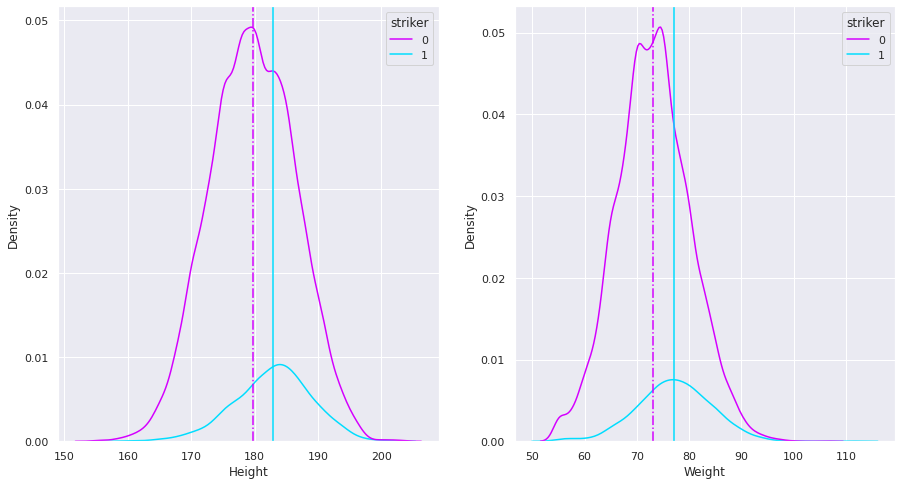

In [30]:
hei_avg_strk = hei_avg[1]
hei_avg_notstrk = hei_avg[0]

wei_avg_strk = wei_avg[1]
wei_avg_notstrk = wei_avg[0]

sns.set()
fig, ax = plt.subplots(1, 2, figsize=(15,8))

sns.kdeplot(data=df_striker, hue='striker', x='Height', palette=['#d400ff', '#00ddff'], ax=ax[0])
ax[0].axvline(hei_avg_strk, color='#00ddff', linestyle='-')
ax[0].axvline(hei_avg_notstrk, color='#d400ff', linestyle='-.')

sns.kdeplot(data=df_striker, hue='striker', x='Weight', palette=['#d400ff', '#00ddff'], ax=ax[1])
ax[1].axvline(wei_avg_strk, color='#00ddff', linestyle='-')
ax[1].axvline(wei_avg_notstrk, color='#d400ff', linestyle='-.')

Dari grafik di atas dapat diketahui bahwa pemain yang berposisi sebagai penyerang secara umum memiliki rata-rata tinggi badan yang lebih tinggi dibanding pemain yang bukan berposisi sebagai penyerang.

Secara umum, rata-rata berat badan pemain yang berposisi sebagai penyerang lebih berat dibanding pemain yang bukan berposisi sebagai penyerang.

### Melihat Perbandingan Attribute Penting Striker Pada Pemain Striker Dan Bukan Striker

In [37]:
pd. set_option('display.max_columns', 25)
df_striker.groupby('striker')[['Bal', 'Str', 'Ant', 'Cmp', 'Dec', 'OtB', 'Tec', 'Vis', 'Wor', 'Fin', 'Fir']].agg({
    'Bal': ['median', 'mean'], 'Str': ['median', 'mean'], 'Ant': ['median', 'mean'], 
    'Cmp': ['median', 'mean'], 'Dec': ['median', 'mean'], 'OtB': ['median', 'mean'], 
    'Tec': ['median', 'mean'], 'Vis': ['median', 'mean'], 'Wor': ['median', 'mean'], 
    'Fin': ['median', 'mean'], 'Fir': ['median', 'mean']
})

Bal               Str               Ant               Cmp  \
        median       mean median       mean median       mean median   
striker                                                                
0         12.0  11.488425   11.0  10.529859   12.0  11.745459   12.0   
1         12.0  11.967239   13.0  11.978939   12.0  12.098284   12.0   

                      Dec               OtB               Tec             \
              mean median       mean median       mean median       mean   
striker                                                                    
0        11.401876   12.0  11.611184   12.0  11.167399   12.0  12.308916   
1        11.827613   12.0  11.496880   13.0  13.110764   12.0  12.175507   

           Vis               Wor               Fin               Fir  \
        median       mean median       mean median       mean median   
striker                                                                
0         11.0  11.231984   13.0  12.457201    9.0   9.068859   12.0   
1         11.0  10.322933   12.0  11.938378   13.0  13.168487   12.0   

                    
              mean  
striker             
0        12.075033  
1        12.210608

Dari 11 attribute yang dianggap mencerminkan pemain yang berposisi penyerang, hasil di atas menunjukkan pada data secara rata-rata kelompok pemain yang berposisi penyerang memiliki rata-rata nilai attribute lebih tinggi daripada kelompok pemain bukan penyerang di 7 attribute yaitu:
  * Balance
  * Strength 
  * Anticipation 
  * Composure
  * Off the ball
  * Finishing
  * First touch

Sedangkan 4 attribute lainnya yaitu:
  * Decision
  * Technique
  * Vision
  * Work rate

Secara rata-rata nilai attribute kelompok pemain berposisi penyerang lebih rendah dibanding kelompok pemain bukan penyerang. Namun hal ini adalah hal yang wajar karena keempat attribute tersebut harus dikuasai dengan baik oleh seluruh pemain sepak bola di manapun posisi mereka bermain

## Modeling

Dalam melakukan permodelan pada analisis ini akan menggunakan 3 model yaitu logit, K nearest neighbors (K-NN), dan random forest

Data yang digunakan dalam analisis ini akan dibagi menjadi 2 yaitu imbalance dan balanced

### Cek Multikoleniaritas

Salah satu model yang akan digunakan dalam analisis ini adalah logistic regression (logit) sehingga perlu dilakukan pengecekan apakah terdapat multikoleniaritas pada fitur-fitur yang ada

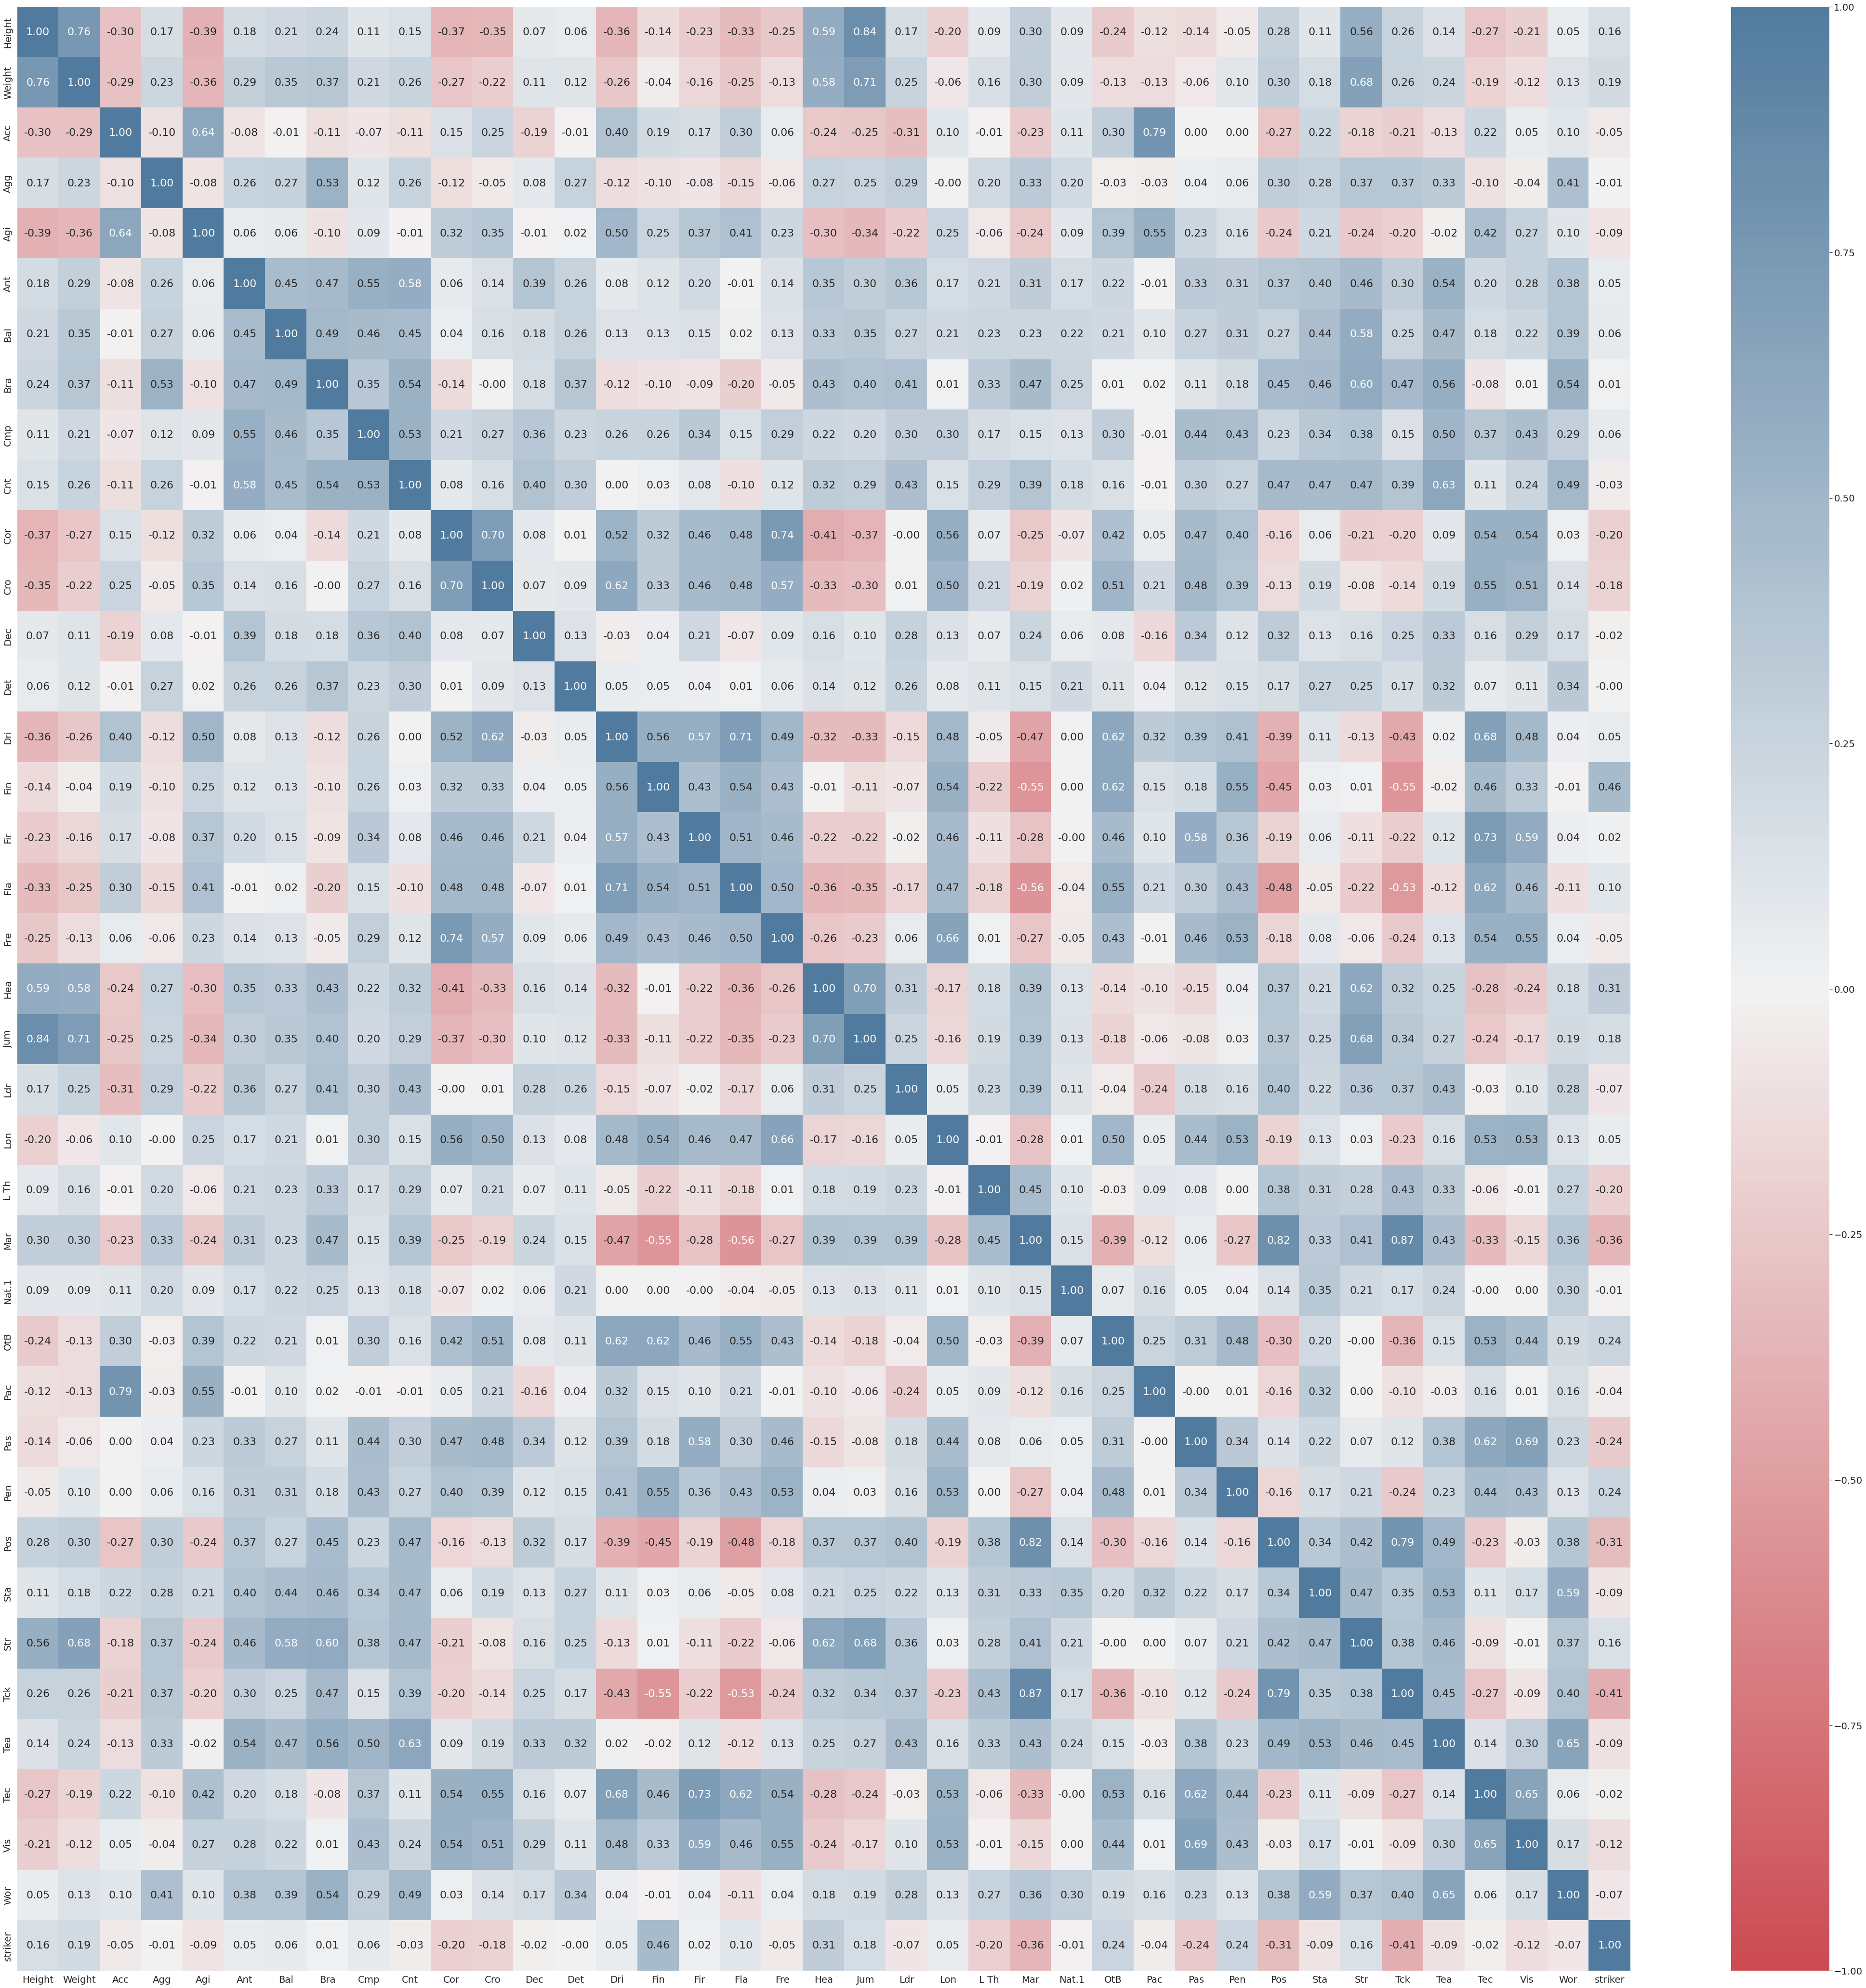

In [ ]:
correlation = df_striker.corr()
plt.figure(figsize=(75,75))
sns.set(font_scale=1.8)
cmap = sns.diverging_palette(10, 240, s=60, as_cmap=True)
sns.heatmap(correlation, vmin=-1, vmax=1, annot=True, annot_kws={"fontsize":22}, fmt='.2f', cmap=cmap)

Dari grafik di atas, terdapat 2 cluster korelasi yaitu:
  * 'Height' - 'Jum', fitur yang didrop adalah 'Height' karena nilai korelasi 'Jum' dengan target ('striker') lebih tinggi dibanding 'Height'
  * 'Mar' - 'Tck' - 'Pos', fitur yang didrop adalah 'Mar' dan 'Pos' karena nilai korelasi 'Tck' dengan target ('striker') lebih tinggi dibanding keduanya

Semua fitur yang akan didrop hanya didrop pada saat akan melakukan modeling dengan logit

### Melakukan Oversampling Dengan Teknik SMOTE

In [ ]:
X_bal = df_striker.drop(['striker'],axis=1)
Y_bal = df_striker['striker']

X_smote, Y_smote = over_sampling.SMOTE(random_state=42).fit_resample(X_bal, Y_bal)

Membandingkan shape data sebelum dan sesudah oversampling

In [ ]:
#Sebelum oversampling
Y_bal.value_counts()

0    8423
1    1282
Name: striker, dtype: int64

In [ ]:
#Setelah oversampling
Y_smote.value_counts()

0    8423
1    8423
Name: striker, dtype: int64

### Striker Attributes Modeling

In [ ]:
X_striker = df_striker[striker_attribute]
Y_striker = df_striker['striker']

#### Imbalance Data

##### Logit

Membagi data menjadi train dan test

In [ ]:
X_train_logit_imb_strk, X_test_logit_imb_strk, Y_train_logit_imb_strk, Y_test_logit_imb_strk = train_test_split(X_striker, Y_striker, test_size=0.20, random_state=42)

###### Permodelan

In [ ]:
logit_imb_model_strk=sm.Logit(Y_train_logit_imb_strk, X_train_logit_imb_strk)
result_logit_imb_strk=logit_imb_model_strk.fit()
print(result_logit_imb_strk.summary2())

Optimization terminated successfully.
         Current function value: 0.204674
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.476    
Dependent Variable: striker          AIC:              3200.1753
Date:               2022-04-05 13:37 BIC:              3276.7051
No. Observations:   7764             Log-Likelihood:   -1589.1  
Df Model:           10               LL-Null:          -3033.3  
Df Residuals:       7753             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     8.0000                                      
------------------------------------------------------------------
         Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
------------------------------------------------------------------
Bal     -0.0466     0.0237    -1.9627   0.0497   -0.0931   -0.0001
Str      0.2230     0.0205    10.8630   0.0000    0.1827    0.2632
Ant

Dari hasil di atas terdapat 2 fitur yang tidak signifikan yaitu Ant dan Cmp, oleh karena itu akan dilakukan permodelan ulang dengan mendrop kedua fitur tersebut

In [ ]:
X_striker_1 = X_striker.drop(['Ant', 'Cmp'], axis = 1)

In [ ]:
X_train_logit_imb_strk, X_test_logit_imb_strk, Y_train_logit_imb_strk, Y_test_logit_imb_strk = train_test_split(X_striker_1, Y_striker, test_size=0.20, random_state=42)

In [ ]:
logit_imb_model_strk=sm.Logit(Y_train_logit_imb_strk, X_train_logit_imb_strk)
result_logit_imb_strk=logit_imb_model_strk.fit()
print(result_logit_imb_strk.summary2())

Optimization terminated successfully.
         Current function value: 0.204936
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.475    
Dependent Variable: striker          AIC:              3200.2517
Date:               2022-04-05 13:37 BIC:              3262.8670
No. Observations:   7764             Log-Likelihood:   -1591.1  
Df Model:           8                LL-Null:          -3033.3  
Df Residuals:       7755             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     8.0000                                      
------------------------------------------------------------------
         Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
------------------------------------------------------------------
Bal     -0.0540     0.0235    -2.2997   0.0215   -0.0999   -0.0080
Str      0.2135     0.0198    10.7688   0.0000    0.1747    0.2524
Dec

Dari hasil di atas semua fitur sudah signifikan

###### Evaluasi Model

In [ ]:
logreg = LogisticRegression()
logreg_imb_strk = logreg.fit(X_train_logit_imb_strk, Y_train_logit_imb_strk)

preds_logit_imb_strk = logreg_imb_strk.predict(X_test_logit_imb_strk)

Confusion Matrix

In [ ]:
logit_imb_strk_confusion_matrix = confusion_matrix(Y_test_logit_imb_strk, preds_logit_imb_strk)
print(logit_imb_strk_confusion_matrix)

[[1636   50]
 [ 101  154]]


Nilai evaluasi AUC, F1 score, Precision, dan Recall

In [ ]:
#AUC score
auc_logit_imb_strk = roc_auc_score(Y_test_logit_imb_strk, preds_logit_imb_strk)
print('AUC Logit imbalance data dengan attribute striker =', auc_logit_imb_strk)

AUC Logit imbalance data dengan attribute striker = 0.787132789058684


In [ ]:
#F1 score
f1_logit_imb_strk = f1_score(Y_test_logit_imb_strk, preds_logit_imb_strk)
print('F1 Score Logit imbalance data dengan attribute striker =', f1_logit_imb_strk)

F1 Score Logit imbalance data dengan attribute striker = 0.6710239651416121


In [ ]:
#Precision score
precision_logit_imb_strk = precision_score(Y_test_logit_imb_strk, preds_logit_imb_strk)
print('Precision Score Logit imbalance data dengan attribute striker =', precision_logit_imb_strk)

Precision Score Logit imbalance data dengan attribute striker = 0.7549019607843137


In [ ]:
#Recall score
recall_logit_imb_strk = recall_score(Y_test_logit_imb_strk, preds_logit_imb_strk)
print('Recall Score Logit imbalance data dengan attribute striker =', recall_logit_imb_strk)

Recall Score Logit imbalance data dengan attribute striker = 0.6039215686274509


##### K-NN

Membagi data menjadi train dan test

In [ ]:
X_train_knn_imb_strk, X_test_knn_imb_strk, Y_train_knn_imb_strk, Y_test_knn_imb_strk = train_test_split(X_striker, Y_striker, test_size=0.20, random_state=42)

###### Permodelan

Hyperparameter tuning

In [ ]:
knn_clf = KNeighborsClassifier()

parameters_knn = {
    'n_neighbors': (2,3,4,5,6,7,8,9,10),
    'weights':('uniform','distance')
}

knn_imb_strk = GridSearchCV(knn_clf, parameters_knn, cv=5, scoring='f1')
knn_imb_strk.fit(X_train_knn_imb_strk, Y_train_knn_imb_strk)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': (2, 3, 4, 5, 6, 7, 8, 9, 10),
                         'weights': ('uniform', 'distance')},
             scoring='f1')

In [ ]:
knn_imb_strk_result = pd.DataFrame(knn_imb_strk.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
knn_imb_strk_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
17,"{'n_neighbors': 10, 'weights': 'distance'}",0.649990,1
15,"{'n_neighbors': 9, 'weights': 'distance'}",0.647839,2
14,"{'n_neighbors': 9, 'weights': 'uniform'}",0.647400,3
10,"{'n_neighbors': 7, 'weights': 'uniform'}",0.646043,4
11,"{'n_neighbors': 7, 'weights': 'distance'}",0.646043,4
13,"{'n_neighbors': 8, 'weights': 'distance'}",0.640100,6
9,"{'n_neighbors': 6, 'weights': 'distance'}",0.638781,7
6,"{'n_neighbors': 5, 'weights': 'uniform'}",0.637120,8
7,"{'n_neighbors': 5, 'weights': 'distance'}",0.637120,8
5,"{'n_neighbors': 4, 'weights': 'distance'}",0.625305,10


###### Evaluasi Model

In [ ]:
preds_knn_imb_strk = knn_imb_strk.best_estimator_.predict(X_test_knn_imb_strk)

Confusion Matrix

In [ ]:
knn_imb_strk_confusion_matrix = confusion_matrix(Y_test_knn_imb_strk, preds_knn_imb_strk)
print(knn_imb_strk_confusion_matrix)

[[1645   41]
 [ 117  138]]


Nilai evaluasi AUC, F1 score, Precision, dan Recall

In [ ]:
#AUC score
auc_knn_imb_strk = roc_auc_score(Y_test_knn_imb_strk, preds_knn_imb_strk)
print('AUC K-NN imbalance data dengan attribute striker =', auc_knn_imb_strk)

AUC K-NN imbalance data dengan attribute striker = 0.7584292791849835


In [ ]:
#F1 score
f1_knn_imb_strk = f1_score(Y_test_knn_imb_strk, preds_knn_imb_strk)
print('F1 Score K-NN imbalance data dengan attribute striker =', f1_knn_imb_strk)

F1 Score K-NN imbalance data dengan attribute striker = 0.6359447004608294


In [ ]:
#Precision score
precision_knn_imb_strk = precision_score(Y_test_knn_imb_strk, preds_knn_imb_strk)
print('Precision Score K-NN imbalance data dengan attribute striker =', precision_knn_imb_strk)

Precision Score K-NN imbalance data dengan attribute striker = 0.770949720670391


In [ ]:
#Recall score
recall_knn_imb_strk = recall_score(Y_test_knn_imb_strk, preds_knn_imb_strk)
print('Recall Score K-NN imbalance data dengan attribute striker =', recall_knn_imb_strk)

Recall Score K-NN imbalance data dengan attribute striker = 0.5411764705882353


##### Random Forest

Membagi data menjadi train dan test

In [ ]:
X_train_rf_imb_strk, X_test_rf_imb_strk, Y_train_rf_imb_strk, Y_test_rf_imb_strk = train_test_split(X_striker, Y_striker, test_size=0.20, random_state=42)

###### Permodelan

Hyperparameter tuning

In [ ]:
rf_clf = RandomForestClassifier(random_state=42)

parameters_rf = {
    'n_estimators': (10,20,30,40,50),
    'max_depth':(1,2,3,4,5,6,7,8,9,10)
}
rf_imb_strk = GridSearchCV(rf_clf, parameters_rf, cv=5, scoring='f1')
rf_imb_strk.fit(X_train_rf_imb_strk, Y_train_rf_imb_strk)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
                         'n_estimators': (10, 20, 30, 40, 50)},
             scoring='f1')

In [ ]:
rf_imb_strk_result = pd.DataFrame(rf_imb_strk.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
rf_imb_strk_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
47,"{'max_depth': 10, 'n_estimators': 30}",0.652818,1
44,"{'max_depth': 9, 'n_estimators': 50}",0.649086,2
43,"{'max_depth': 9, 'n_estimators': 40}",0.645174,3
49,"{'max_depth': 10, 'n_estimators': 50}",0.644714,4
42,"{'max_depth': 9, 'n_estimators': 30}",0.641791,5
...,...,...,...
4,"{'max_depth': 1, 'n_estimators': 50}",0.000000,42
3,"{'max_depth': 1, 'n_estimators': 40}",0.000000,42
2,"{'max_depth': 1, 'n_estimators': 30}",0.000000,42
1,"{'max_depth': 1, 'n_estimators': 20}",0.000000,42


###### Evaluasi Model

In [ ]:
preds_rf_imb_strk = rf_imb_strk.best_estimator_.predict(X_test_rf_imb_strk)

Confusion Matrix

In [ ]:
rf_imb_strk_confusion_matrix = confusion_matrix(Y_test_rf_imb_strk, preds_rf_imb_strk)
print(rf_imb_strk_confusion_matrix)

[[1646   40]
 [ 116  139]]


Nilai evaluasi AUC, F1 score, Precision, dan Recall

In [ ]:
#AUC score
auc_rf_imb_strk = roc_auc_score(Y_test_rf_imb_strk, preds_rf_imb_strk)
print('AUC Random Forest imbalance data dengan attribute striker =', auc_rf_imb_strk)

AUC Random Forest imbalance data dengan attribute striker = 0.7606866234038098


In [ ]:
#F1 score
f1_rf_imb_strk = f1_score(Y_test_rf_imb_strk, preds_rf_imb_strk)
print('F1 Score Random Forest imbalance data dengan attribute striker =', f1_rf_imb_strk)

F1 Score Random Forest imbalance data dengan attribute striker = 0.640552995391705


In [ ]:
#Precision score
precision_rf_imb_strk = precision_score(Y_test_rf_imb_strk, preds_rf_imb_strk)
print('Precision Score Random Forest imbalance data dengan attribute striker =', precision_rf_imb_strk)

Precision Score Random Forest imbalance data dengan attribute striker = 0.776536312849162


In [ ]:
#Recall score
recall_rf_imb_strk = recall_score(Y_test_rf_imb_strk, preds_rf_imb_strk)
print('Recall Score Random Forest imbalance data dengan attribute striker =', recall_rf_imb_strk)

Recall Score Random Forest imbalance data dengan attribute striker = 0.5450980392156862


#### Balanced Data

Memfilter fitur pada variabel X_smote

In [ ]:
X_smote_strk = X_smote[striker_attribute]

##### Logit

Membagi data menjadi train dan test

In [ ]:
X_train_logit_bal_strk, X_test_logit_bal_strk, Y_train_logit_bal_strk, Y_test_logit_bal_strk = train_test_split(X_smote_strk, Y_smote, test_size=0.20, random_state=42)

###### Permodelan

In [ ]:
logit_bal_model_strk=sm.Logit(Y_train_logit_bal_strk, X_train_logit_bal_strk)
result_logit_bal_strk=logit_bal_model_strk.fit()
print(result_logit_bal_strk.summary2())

Optimization terminated successfully.
         Current function value: 0.274721
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.604    
Dependent Variable: striker          AIC:              7426.2886
Date:               2022-04-05 12:39 BIC:              7508.8839
No. Observations:   13476            Log-Likelihood:   -3702.1  
Df Model:           10               LL-Null:          -9340.8  
Df Residuals:       13465            LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     8.0000                                      
------------------------------------------------------------------
         Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
------------------------------------------------------------------
Bal     -0.0425     0.0174    -2.4390   0.0147   -0.0766   -0.0083
Str      0.2245     0.0143    15.6813   0.0000    0.1964    0.2526
Ant

Dari hasil di atas terdapat 1 fitur yang tidak signifikan yaitu Ant, oleh karena itu akan dilakukan permodelan ulang dengan mendrop fitur tersebut

In [ ]:
X_striker_2 = X_smote_strk.drop(['Ant'], axis = 1)

In [ ]:
X_train_logit_bal_strk, X_test_logit_bal_strk, Y_train_logit_bal_strk, Y_test_logit_bal_strk = train_test_split(X_striker_2, Y_smote, test_size=0.20, random_state=42)

In [ ]:
logit_bal_model_strk=sm.Logit(Y_train_logit_bal_strk, X_train_logit_bal_strk)
result_logit_bal_strk=logit_bal_model_strk.fit()
print(result_logit_bal_strk.summary2())

Optimization terminated successfully.
         Current function value: 0.274736
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.604    
Dependent Variable: striker          AIC:              7424.6818
Date:               2022-04-05 12:39 BIC:              7499.7685
No. Observations:   13476            Log-Likelihood:   -3702.3  
Df Model:           9                LL-Null:          -9340.8  
Df Residuals:       13466            LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     8.0000                                      
------------------------------------------------------------------
         Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
------------------------------------------------------------------
Bal     -0.0420     0.0174    -2.4158   0.0157   -0.0761   -0.0079
Str      0.2264     0.0140    16.1606   0.0000    0.1989    0.2538
Cmp

Dari hasil di atas semua fitur sudah signifikan

###### Evaluasi Model

In [ ]:
logreg_bal_strk = logreg.fit(X_train_logit_bal_strk, Y_train_logit_bal_strk)

preds_logit_bal_strk = logreg_bal_strk.predict(X_test_logit_bal_strk)

Confusion Matrix

In [ ]:
logit_bal_strk_confusion_matrix = confusion_matrix(Y_test_logit_bal_strk, preds_logit_bal_strk)
print(logit_bal_strk_confusion_matrix)

[[1490  218]
 [ 160 1502]]


Nilai evaluasi AUC, F1 score, Precision, dan Recall

In [ ]:
#Accuracy score
accuracy_logit_bal_strk = accuracy_score(Y_test_logit_bal_strk, preds_logit_bal_strk)
print('Accuracy Logit balanced data dengan attribute striker =', accuracy_logit_bal_strk)

Accuracy Logit balanced data dengan attribute striker = 0.8878338278931751


In [ ]:
#F1 score
f1_logit_bal_strk = f1_score(Y_test_logit_bal_strk, preds_logit_bal_strk)
print('F1 Score Logit balanced data dengan attribute striker =', f1_logit_bal_strk)

F1 Score Logit balanced data dengan attribute striker = 0.8882318154937907


In [ ]:
#Precision score
precision_logit_bal_strk = precision_score(Y_test_logit_bal_strk, preds_logit_bal_strk)
print('Precision Score Logit balanced data dengan attribute striker =', precision_logit_bal_strk)

Precision Score Logit balanced data dengan attribute striker = 0.8732558139534884


In [ ]:
#Recall score
recall_logit_bal_strk = recall_score(Y_test_logit_bal_strk, preds_logit_bal_strk)
print('Recall Score Logit balanced data dengan attribute striker =', recall_logit_bal_strk)

Recall Score Logit balanced data dengan attribute striker = 0.9037304452466908


##### K-NN

Membagi data menjadi train dan test

In [ ]:
X_train_knn_bal_strk, X_test_knn_bal_strk, Y_train_knn_bal_strk, Y_test_knn_bal_strk = train_test_split(X_smote_strk, Y_smote, test_size=0.20, random_state=42)

###### Permodelan

Hyperparameter tuning

In [ ]:
knn_bal_strk = GridSearchCV(knn_clf, parameters_knn, cv=5, scoring='f1')
knn_bal_strk.fit(X_train_knn_bal_strk, Y_train_knn_bal_strk)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': (2, 3, 4, 5, 6, 7, 8, 9, 10),
                         'weights': ('uniform', 'distance')},
             scoring='f1')

In [ ]:
knn_bal_strk_result = pd.DataFrame(knn_bal_strk.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
knn_bal_strk_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
0,"{'n_neighbors': 2, 'weights': 'uniform'}",0.937604,1
1,"{'n_neighbors': 2, 'weights': 'distance'}",0.935459,2
5,"{'n_neighbors': 4, 'weights': 'distance'}",0.930806,3
4,"{'n_neighbors': 4, 'weights': 'uniform'}",0.929541,4
3,"{'n_neighbors': 3, 'weights': 'distance'}",0.927103,5
9,"{'n_neighbors': 6, 'weights': 'distance'}",0.926617,6
2,"{'n_neighbors': 3, 'weights': 'uniform'}",0.925389,7
7,"{'n_neighbors': 5, 'weights': 'distance'}",0.924149,8
13,"{'n_neighbors': 8, 'weights': 'distance'}",0.924126,9
8,"{'n_neighbors': 6, 'weights': 'uniform'}",0.922731,10


###### Evaluasi Model

In [ ]:
preds_knn_bal_strk = knn_bal_strk.best_estimator_.predict(X_test_knn_bal_strk)

Confusion Matrix

In [ ]:
knn_bal_strk_confusion_matrix = confusion_matrix(Y_test_knn_bal_strk, preds_knn_bal_strk)
print(knn_bal_strk_confusion_matrix)

[[1576  132]
 [  58 1604]]


Nilai evaluasi Accuracy, F1 score, Precision, dan Recall

In [ ]:
#Accuracy score
accuracy_knn_bal_strk = roc_auc_score(Y_test_knn_bal_strk, preds_knn_bal_strk)
print('Accuracy K-NN balanced data dengan attribute striker =', accuracy_knn_bal_strk)

Accuracy K-NN balanced data dengan attribute striker = 0.943909457018293


In [ ]:
#F1 score
f1_knn_bal_strk = f1_score(Y_test_knn_bal_strk, preds_knn_bal_strk)
print('F1 Score K-NN balanced data dengan attribute striker =', f1_knn_bal_strk)

F1 Score K-NN balanced data dengan attribute striker = 0.9440847557386698


In [ ]:
#Precision score
precision_knn_bal_strk = precision_score(Y_test_knn_bal_strk, preds_knn_bal_strk)
print('Precision Score K-NN balanced data dengan attribute striker =', precision_knn_bal_strk)

Precision Score K-NN balanced data dengan attribute striker = 0.923963133640553


In [ ]:
#Recall score
recall_knn_bal_strk = recall_score(Y_test_knn_bal_strk, preds_knn_bal_strk)
print('Recall Score K-NN balanced data dengan attribute striker =', recall_knn_bal_strk)

Recall Score K-NN balanced data dengan attribute striker = 0.9651022864019254


##### Random Forest

Membagi data menjadi train dan test

In [ ]:
X_train_rf_bal_strk, X_test_rf_bal_strk, Y_train_rf_bal_strk, Y_test_rf_bal_strk = train_test_split(X_smote_strk, Y_smote, test_size=0.20, random_state=42)

###### Permodelan

Hyperparameter tuning

In [ ]:
rf_bal_strk = GridSearchCV(rf_clf, parameters_rf, cv=5, scoring='f1')
rf_bal_strk.fit(X_train_rf_bal_strk, Y_train_rf_bal_strk)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
                         'n_estimators': (10, 20, 30, 40, 50)},
             scoring='f1')

In [ ]:
rf_bal_strk_result = pd.DataFrame(rf_bal_strk.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
rf_bal_strk_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
49,"{'max_depth': 10, 'n_estimators': 50}",0.950275,1
48,"{'max_depth': 10, 'n_estimators': 40}",0.949475,2
47,"{'max_depth': 10, 'n_estimators': 30}",0.949346,3
46,"{'max_depth': 10, 'n_estimators': 20}",0.948714,4
45,"{'max_depth': 10, 'n_estimators': 10}",0.947875,5
...,...,...,...
1,"{'max_depth': 1, 'n_estimators': 20}",0.872528,46
2,"{'max_depth': 1, 'n_estimators': 30}",0.863649,47
3,"{'max_depth': 1, 'n_estimators': 40}",0.862206,48
0,"{'max_depth': 1, 'n_estimators': 10}",0.862039,49


###### Evaluasi Model

In [ ]:
preds_rf_bal_strk = rf_bal_strk.best_estimator_.predict(X_test_rf_bal_strk)

Confusion Matrix

In [ ]:
rf_bal_strk_confusion_matrix = confusion_matrix(Y_test_rf_bal_strk, preds_rf_bal_strk)
print(rf_bal_strk_confusion_matrix)

[[1590  118]
 [  87 1575]]


Nilai evaluasi Accuracy, F1 score, Precision, dan Recall

In [ ]:
#Accuracy score
accuracy_rf_bal_strk = accuracy_score(Y_test_rf_bal_strk, preds_rf_bal_strk)
print('AUC Random Forest balanced data dengan attribute striker =', accuracy_rf_bal_strk)

AUC Random Forest balanced data dengan attribute striker = 0.9391691394658753


In [ ]:
#F1 score
f1_rf_bal_strk = f1_score(Y_test_rf_bal_strk, preds_rf_bal_strk)
print('F1 Score Random Forest balanced data dengan attribute striker =', f1_rf_bal_strk)

F1 Score Random Forest balanced data dengan attribute striker = 0.9388971684053652


In [ ]:
#Precision score
precision_rf_bal_strk = precision_score(Y_test_rf_bal_strk, preds_rf_bal_strk)
print('Precision Score Random Forest balanced data dengan attribute striker =', precision_rf_bal_strk)

Precision Score Random Forest balanced data dengan attribute striker = 0.9303012404016539


In [ ]:
#Recall score
recall_rf_bal_strk = recall_score(Y_test_rf_bal_strk, preds_rf_bal_strk)
print('Recall Score Random Forest balanced data dengan attribute striker =', recall_rf_bal_strk)

Recall Score Random Forest balanced data dengan attribute striker = 0.9476534296028881


### All Attributes Modeling

Membuat variabel dependen dan independen

In [ ]:
X = df_striker.drop(['striker'], axis = 1)
Y = df_striker['striker']

#### Imbalance Data

##### Logit

Mendrop fitur yang menyebabkan multikoleniaritas

In [ ]:
X_logit = df_striker.drop(['striker', 'Height', 'Mar', 'Pos'], axis = 1)

Membagi data menjadi train dan test

In [ ]:
X_train_logit_imb, X_test_logit_imb, Y_train_logit_imb, Y_test_logit_imb = train_test_split(X_logit, Y, test_size=0.20, random_state=42)

###### Permodelan

In [ ]:
logit_imb_model=sm.Logit(Y_train_logit_imb, X_train_logit_imb)
result_logit_imb=logit_imb_model.fit()
print(result_logit_imb.summary2())

Optimization terminated successfully.
         Current function value: 0.111199
         Iterations 9
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.715    
Dependent Variable: striker          AIC:              1796.6905
Date:               2022-04-05 12:41 BIC:              2040.1943
No. Observations:   7764             Log-Likelihood:   -863.35  
Df Model:           34               LL-Null:          -3033.3  
Df Residuals:       7729             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     9.0000                                      
-----------------------------------------------------------------
             Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
Weight       0.0034    0.0092    0.3745  0.7081  -0.0146   0.0215
Acc         -0.1613    0.0568   -2.8401  0.0045  -0.2727  -0.0500
Agg     

Dari hasil di atas terdapat 16 fitur yang tidak signifikan yaitu Weight, Agg, Agi, Ant, Cnt, Cor, Dec, Fir, Fla, Fre, Jum, L Th, Pac, Sta, Tec, Vis, Wor  oleh karena itu akan dilakukan permodelan ulang dengan mendrop semua fitur tersebut

In [ ]:
X_striker_3 = X_logit.drop(['Weight', 'Agg', 'Agi', 'Ant', 'Cnt', 'Cor', 'Dec', 'Fir', 'Fla', 'Fre', 'Jum', 'L Th', 'Pac', 'Sta', 'Tec', 'Vis', 'Wor'], axis = 1)

In [ ]:
X_train_logit_imb, X_test_logit_imb, Y_train_logit_imb, Y_test_logit_imb = train_test_split(X_striker_3, Y, test_size=0.20, random_state=42)

In [ ]:
logit_imb_model=sm.Logit(Y_train_logit_imb, X_train_logit_imb)
result_logit_imb=logit_imb_model.fit()
print(result_logit_imb.summary2())

Optimization terminated successfully.
         Current function value: 0.113128
         Iterations 9
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.710    
Dependent Variable: striker          AIC:              1792.6493
Date:               2022-04-05 12:47 BIC:              1917.8799
No. Observations:   7764             Log-Likelihood:   -878.32  
Df Model:           17               LL-Null:          -3033.3  
Df Residuals:       7746             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     9.0000                                      
------------------------------------------------------------------
         Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
------------------------------------------------------------------
Acc     -0.3467     0.0324   -10.7057   0.0000   -0.4102   -0.2832
Bal      0.0981     0.0331     2.9592   0.0031    0.0331    0.1631
Bra

Dari hasil di atas semua fitur sudah signifikan

###### Evaluasi Model

In [ ]:
logreg_imb = logreg.fit(X_train_logit_imb, Y_train_logit_imb)

preds_logit_imb = logreg_imb.predict(X_test_logit_imb)

Confusion Matrix

In [ ]:
logit_imb_confusion_matrix = confusion_matrix(Y_test_logit_imb, preds_logit_imb)
print(logit_imb_confusion_matrix)

[[1649   37]
 [  61  194]]


Nilai evaluasi AUC, F1 score, Precision, dan Recall

In [ ]:
#AUC score
auc_logit_imb = roc_auc_score(Y_test_logit_imb, preds_logit_imb)
print('AUC Logit imbalance data all attributes =', auc_logit_imb)

AUC Logit imbalance data all attributes = 0.8694194403740143


In [ ]:
#F1 score
f1_logit_imb = f1_score(Y_test_logit_imb, preds_logit_imb)
print('F1 Score Logit imbalance data all attributes =', f1_logit_imb)

F1 Score Logit imbalance data all attributes = 0.7983539094650205


In [ ]:
#Precision score
precision_logit_imb = precision_score(Y_test_logit_imb, preds_logit_imb)
print('Precision Score Logit imbalance data all attributes =', precision_logit_imb)

Precision Score Logit imbalance data all attributes = 0.8398268398268398


In [ ]:
#Recall score
recall_logit_imb = recall_score(Y_test_logit_imb, preds_logit_imb)
print('Recall Score Logit imbalance data all attributes =', recall_logit_imb)

Recall Score Logit imbalance data all attributes = 0.7607843137254902


##### K-NN

Membagi data menjadi train dan test

In [ ]:
X_train_knn_imb, X_test_knn_imb, Y_train_knn_imb, Y_test_knn_imb = train_test_split(X, Y, test_size=0.20, random_state=42)

###### Permodelan

Hyperparameter tuning

In [ ]:
knn_imb = GridSearchCV(knn_clf, parameters_knn, cv=5, scoring='f1')
knn_imb.fit(X_train_knn_imb, Y_train_knn_imb)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': (2, 3, 4, 5, 6, 7, 8, 9, 10),
                         'weights': ('uniform', 'distance')},
             scoring='f1')

In [ ]:
knn_imb_result = pd.DataFrame(knn_imb.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
knn_imb_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
13,"{'n_neighbors': 8, 'weights': 'distance'}",0.799276,1
10,"{'n_neighbors': 7, 'weights': 'uniform'}",0.796478,2
11,"{'n_neighbors': 7, 'weights': 'distance'}",0.796478,2
17,"{'n_neighbors': 10, 'weights': 'distance'}",0.795428,4
15,"{'n_neighbors': 9, 'weights': 'distance'}",0.793863,5
14,"{'n_neighbors': 9, 'weights': 'uniform'}",0.793863,5
9,"{'n_neighbors': 6, 'weights': 'distance'}",0.791721,7
6,"{'n_neighbors': 5, 'weights': 'uniform'}",0.789463,8
7,"{'n_neighbors': 5, 'weights': 'distance'}",0.789463,8
12,"{'n_neighbors': 8, 'weights': 'uniform'}",0.781206,10


###### Evaluasi Model

In [ ]:
preds_knn_imb = knn_imb.best_estimator_.predict(X_test_knn_imb)

Confusion Matrix

In [ ]:
knn_imb_confusion_matrix = confusion_matrix(Y_test_knn_imb, preds_knn_imb)
print(knn_imb_confusion_matrix)

[[1658   28]
 [  66  189]]


Nilai evaluasi AUC, F1 score, Precision, dan Recall

In [ ]:
#AUC score
auc_knn_imb = roc_auc_score(Y_test_knn_imb, preds_knn_imb)
print('AUC K-NN imbalance data all attributes =', auc_knn_imb)

AUC K-NN imbalance data all attributes = 0.8622845579512944


In [ ]:
#F1 score
f1_knn_imb = f1_score(Y_test_knn_imb, preds_knn_imb)
print('F1 Score K-NN imbalance data all attributes =', f1_knn_imb)

F1 Score K-NN imbalance data all attributes = 0.8008474576271186


In [ ]:
#Precision score
precision_knn_imb = precision_score(Y_test_knn_imb, preds_knn_imb)
print('Precision Score K-NN imbalance data all attributes =', precision_knn_imb)

Precision Score K-NN imbalance data all attributes = 0.8709677419354839


In [ ]:
#Recall score
recall_knn_imb = recall_score(Y_test_knn_imb, preds_knn_imb)
print('Recall Score K-NN imbalance data all attributes =', recall_knn_imb)

Recall Score K-NN imbalance data all attributes = 0.7411764705882353


##### Random Forest

Membagi data menjadi train dan test

In [ ]:
X_train_rf_imb, X_test_rf_imb, Y_train_rf_imb, Y_test_rf_imb = train_test_split(X, Y, test_size=0.20, random_state=42)

###### Permodelan

Hyperparameter tuning

In [ ]:
rf_imb = GridSearchCV(rf_clf, parameters_rf, cv=5, scoring='f1')
rf_imb.fit(X_train_rf_imb, Y_train_rf_imb)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
                         'n_estimators': (10, 20, 30, 40, 50)},
             scoring='f1')

In [ ]:
rf_imb_result = pd.DataFrame(rf_imb.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
rf_imb_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
49,"{'max_depth': 10, 'n_estimators': 50}",0.801639,1
48,"{'max_depth': 10, 'n_estimators': 40}",0.800636,2
44,"{'max_depth': 9, 'n_estimators': 50}",0.798629,3
47,"{'max_depth': 10, 'n_estimators': 30}",0.796598,4
43,"{'max_depth': 9, 'n_estimators': 40}",0.796261,5
...,...,...,...
4,"{'max_depth': 1, 'n_estimators': 50}",0.000000,46
3,"{'max_depth': 1, 'n_estimators': 40}",0.000000,46
2,"{'max_depth': 1, 'n_estimators': 30}",0.000000,46
1,"{'max_depth': 1, 'n_estimators': 20}",0.000000,46


###### Evaluasi Model

In [ ]:
preds_rf_imb = rf_imb.best_estimator_.predict(X_test_rf_imb)

Confusion Matrix

In [ ]:
rf_imb_confusion_matrix = confusion_matrix(Y_test_rf_imb, preds_rf_imb)
print(rf_imb_confusion_matrix)

[[1661   25]
 [  58  197]]


Nilai evaluasi AUC, F1 score, Precision, dan Recall

In [ ]:
#AUC score
auc_rf_imb = roc_auc_score(Y_test_rf_imb, preds_rf_imb)
print('AUC Random Forest imblance data =', auc_rf_imb)

AUC Random Forest imblance data = 0.8788605121764007


In [ ]:
#F1 score
f1_rf_imb = f1_score(Y_test_rf_imb, preds_rf_imb)
print('F1 Score Random Forest imblance data =', f1_rf_imb)

F1 Score Random Forest imblance data = 0.8259958071278827


In [ ]:
#Precision score
precision_rf_imb = precision_score(Y_test_rf_imb, preds_rf_imb)
print('Precision Score Random Forest imblance data =', precision_rf_imb)

Precision Score Random Forest imblance data = 0.8873873873873874


In [ ]:
#Recall score
recall_rf_imb = recall_score(Y_test_rf_imb, preds_rf_imb)
print('Recall Score Random Forest imblance data =', recall_rf_imb)

Recall Score Random Forest imblance data = 0.7725490196078432


#### Balanced Data

##### Logit

Mendrop fitur yang menyebabkan multikoleniaritas

In [ ]:
X_smote_logit = X_smote.drop(['Height', 'Mar', 'Pos'], axis = 1)

Membagi data menjadi train dan test

In [ ]:
X_train_logit_bal, X_test_logit_bal, Y_train_logit_bal, Y_test_logit_bal = train_test_split(X_smote_logit, Y_smote, test_size=0.20, random_state=42)

###### Permodelan

In [ ]:
logit_bal_model=sm.Logit(Y_train_logit_bal, X_train_logit_bal)
result_logit_bal=logit_bal_model.fit()
print(result_logit_bal.summary2())

Optimization terminated successfully.
         Current function value: 0.141639
         Iterations 9
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.796    
Dependent Variable: striker          AIC:              3887.4656
Date:               2022-04-05 13:02 BIC:              4150.2689
No. Observations:   13476            Log-Likelihood:   -1908.7  
Df Model:           34               LL-Null:          -9340.8  
Df Residuals:       13441            LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     9.0000                                      
-----------------------------------------------------------------
             Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
Weight       0.0105    0.0069    1.5195  0.1286  -0.0030   0.0239
Acc         -0.0794    0.0441   -1.8016  0.0716  -0.1658   0.0070
Agg     

Dari hasil di atas terdapat 16 fitur yang tidak signifikan yaitu Weight, 'Acc', Agg, Agi, Ant, Cmp, Cnt, Dec, Fir, Fla, Fre, Jum, L Th, Sta, Vis, Wor oleh karena itu akan dilakukan permodelan ulang dengan mendrop semua fitur tersebut

In [ ]:
X_striker_4 = X_smote_logit.drop(['Weight', 'Acc', 'Agg', 'Agi', 'Ant', 'Cmp', 'Cnt', 'Dec', 'Fir', 'Fla', 'Fre', 'Jum', 'L Th', 'Sta', 'Vis', 'Wor'], axis = 1)

In [ ]:
X_train_logit_bal, X_test_logit_bal, Y_train_logit_bal, Y_test_logit_bal = train_test_split(X_striker_4, Y_smote, test_size=0.20, random_state=42)

In [ ]:
logit_bal_model=sm.Logit(Y_train_logit_bal, X_train_logit_bal)
result_logit_bal=logit_bal_model.fit()
print(result_logit_bal.summary2())

Optimization terminated successfully.
         Current function value: 0.142650
         Iterations 9
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.794    
Dependent Variable: striker          AIC:              3882.7075
Date:               2022-04-05 13:09 BIC:              4025.3722
No. Observations:   13476            Log-Likelihood:   -1922.4  
Df Model:           18               LL-Null:          -9340.8  
Df Residuals:       13457            LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     9.0000                                      
------------------------------------------------------------------
         Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
------------------------------------------------------------------
Bal      0.0852     0.0242     3.5232   0.0004    0.0378    0.1327
Bra      0.1177     0.0219     5.3622   0.0000    0.0747    0.1607
Cor

Dari hasil di atas terdapat 1 fitur yang tidak signifikan yaitu Tec, maka akan dilakukan permodelan ulang dengan mendrop fitur tersebut

In [ ]:
X_striker_5 = X_striker_4.drop(['Tec'], axis = 1)

In [ ]:
X_train_logit_bal, X_test_logit_bal, Y_train_logit_bal, Y_test_logit_bal = train_test_split(X_striker_5, Y_smote, test_size=0.20, random_state=42)

In [ ]:
logit_bal_model=sm.Logit(Y_train_logit_bal, X_train_logit_bal)
result_logit_bal=logit_bal_model.fit()
print(result_logit_bal.summary2())

Optimization terminated successfully.
         Current function value: 0.142751
         Iterations 9
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.794    
Dependent Variable: striker          AIC:              3883.4263
Date:               2022-04-05 13:10 BIC:              4018.5823
No. Observations:   13476            Log-Likelihood:   -1923.7  
Df Model:           17               LL-Null:          -9340.8  
Df Residuals:       13458            LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     9.0000                                      
------------------------------------------------------------------
         Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
------------------------------------------------------------------
Bal      0.0848     0.0242     3.5098   0.0004    0.0375    0.1322
Bra      0.1186     0.0219     5.4074   0.0000    0.0756    0.1616
Cor

Dari hasil di atas semua fitur sudah signifikan

###### Evaluasi Model

In [ ]:
logreg_bal = logreg.fit(X_train_logit_bal, Y_train_logit_bal)

preds_logit_bal = logreg_bal.predict(X_test_logit_bal)

Confusion Matrix

In [ ]:
logit_bal_confusion_matrix = confusion_matrix(Y_test_logit_bal, preds_logit_bal)
print(logit_bal_confusion_matrix)

[[1584  124]
 [  77 1585]]


Nilai evaluasi AUC, F1 score, Precision, dan Recall

In [ ]:
#Accuracy score
accuracy_logit_bal = accuracy_score(Y_test_logit_bal, preds_logit_bal)
print('Accuracy Score Logit balanced data all attributes =', accuracy_logit_bal)

Accuracy Score Logit balanced data all attributes = 0.9403560830860535


In [ ]:
#F1 score
f1_logit_bal = f1_score(Y_test_logit_bal, preds_logit_bal)
print('F1 Score Logit balanced data all attributes =', f1_logit_bal)

F1 Score Logit balanced data all attributes = 0.9403737763274992


In [ ]:
#Precision score
precision_logit_bal = precision_score(Y_test_logit_bal, preds_logit_bal)
print('Precision Score Logit balanced data all attributes =', precision_logit_bal)

Precision Score Logit balanced data all attributes = 0.9274429490930368


In [ ]:
#Recall score
recall_logit_bal = recall_score(Y_test_logit_bal, preds_logit_bal)
print('Recall Score Logit balanced data all attributes =', recall_logit_bal)

Recall Score Logit balanced data all attributes = 0.95367027677497


##### K-NN

Membagi data menjadi train dan test

In [ ]:
X_train_knn_bal, X_test_knn_bal, Y_train_knn_bal, Y_test_knn_bal = train_test_split(X_smote, Y_smote, test_size=0.20, random_state=42)

###### Permodelan

Hyperparameter tuning

In [ ]:
knn_bal = GridSearchCV(knn_clf, parameters_knn, cv=5, scoring='f1')
knn_bal.fit(X_train_knn_bal, Y_train_knn_bal)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': (2, 3, 4, 5, 6, 7, 8, 9, 10),
                         'weights': ('uniform', 'distance')},
             scoring='f1')

In [ ]:
knn_bal_result = pd.DataFrame(knn_bal.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
knn_bal_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
0,"{'n_neighbors': 2, 'weights': 'uniform'}",0.967278,1
1,"{'n_neighbors': 2, 'weights': 'distance'}",0.959274,2
4,"{'n_neighbors': 4, 'weights': 'uniform'}",0.958184,3
5,"{'n_neighbors': 4, 'weights': 'distance'}",0.954601,4
3,"{'n_neighbors': 3, 'weights': 'distance'}",0.953228,5
2,"{'n_neighbors': 3, 'weights': 'uniform'}",0.952858,6
8,"{'n_neighbors': 6, 'weights': 'uniform'}",0.952742,7
9,"{'n_neighbors': 6, 'weights': 'distance'}",0.950035,8
12,"{'n_neighbors': 8, 'weights': 'uniform'}",0.949449,9
13,"{'n_neighbors': 8, 'weights': 'distance'}",0.948086,10


###### Evaluasi Model

In [ ]:
preds_knn_bal = knn_bal.best_estimator_.predict(X_test_knn_bal)

Confusion Matrix

In [ ]:
knn_bal_confusion_matrix = confusion_matrix(Y_test_knn_bal, preds_knn_bal)
print(knn_bal_confusion_matrix)

[[1593  115]
 [   1 1661]]


Nilai evaluasi Accuracy, F1 score, Precision, dan Recall

In [ ]:
#Accuracy score
accuracy_knn_bal = accuracy_score(Y_test_knn_bal, preds_knn_bal)
print('Accuracy Score K-NN imbalance data all attributes =', accuracy_knn_bal)

Accuracy Score K-NN imbalance data all attributes = 0.9655786350148368


In [ ]:
#F1 score
f1_knn_bal = f1_score(Y_test_knn_bal, preds_knn_bal)
print('F1 Score K-NN balanced data all attributes =', f1_knn_bal)

F1 Score K-NN balanced data all attributes = 0.966259453170448


In [ ]:
#Precision score
precision_knn_bal = precision_score(Y_test_knn_bal, preds_knn_bal)
print('Precision Score K-NN balanced data all attributes =', precision_knn_bal)

Precision Score K-NN balanced data all attributes = 0.9352477477477478


In [ ]:
#Recall score
recall_knn_bal = recall_score(Y_test_knn_bal, preds_knn_bal)
print('Recall Score K-NN balanced data all attributes =', recall_knn_bal)

Recall Score K-NN balanced data all attributes = 0.9993983152827918


##### Random Forest

Membagi data menjadi train dan test

In [ ]:
X_train_rf_bal, X_test_rf_bal, Y_train_rf_bal, Y_test_rf_bal = train_test_split(X_smote, Y_smote, test_size=0.20, random_state=42)

###### Permodelan

Hyperparameter tuning

In [ ]:
rf_bal = GridSearchCV(rf_clf, parameters_rf, cv=5, scoring='f1')
rf_bal.fit(X_train_rf_bal, Y_train_rf_bal)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': (1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
                         'n_estimators': (10, 20, 30, 40, 50)},
             scoring='f1')

In [ ]:
rf_bal_result = pd.DataFrame(rf_bal.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
rf_bal_result[retain_cols].sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
49,"{'max_depth': 10, 'n_estimators': 50}",0.973530,1
48,"{'max_depth': 10, 'n_estimators': 40}",0.973188,2
47,"{'max_depth': 10, 'n_estimators': 30}",0.972633,3
43,"{'max_depth': 9, 'n_estimators': 40}",0.972340,4
44,"{'max_depth': 9, 'n_estimators': 50}",0.972043,5
...,...,...,...
4,"{'max_depth': 1, 'n_estimators': 50}",0.904409,46
2,"{'max_depth': 1, 'n_estimators': 30}",0.903163,47
3,"{'max_depth': 1, 'n_estimators': 40}",0.902812,48
1,"{'max_depth': 1, 'n_estimators': 20}",0.888835,49


###### Evaluasi Model

In [ ]:
preds_rf_bal = rf_bal.best_estimator_.predict(X_test_rf_bal)

Confusion Matrix

In [ ]:
rf_bal_confusion_matrix = confusion_matrix(Y_test_rf_bal, preds_rf_bal)
print(rf_bal_confusion_matrix)

[[1644   64]
 [  27 1635]]


Nilai evaluasi Accuracy, F1 score, Precision, dan Recall

In [ ]:
#Accuracy score
accuracy_rf_bal = accuracy_score(Y_test_rf_bal, preds_rf_bal)
print('Accuracy Score Random Forest balanced data all attributes =', accuracy_rf_bal)

Accuracy Score Random Forest balanced data all attributes = 0.9729970326409495


In [ ]:
#F1 score
f1_rf_bal = f1_score(Y_test_rf_bal, preds_rf_bal)
print('F1 Score Random Forest balanced data all attributes =', f1_rf_bal)

F1 Score Random Forest balanced data all attributes = 0.9729247247842903


In [ ]:
#Precision score
precision_rf_bal = precision_score(Y_test_rf_bal, preds_rf_bal)
print('Precision Score Random Forest balanced data all attributes =', precision_rf_bal)

Precision Score Random Forest balanced data all attributes = 0.9623307828134197


In [ ]:
#Recall score
recall_rf_bal = recall_score(Y_test_rf_bal, preds_rf_bal)
print('Recall Score Random Forest balanced data all attributes =', recall_rf_bal)

Recall Score Random Forest balanced data all attributes = 0.983754512635379


## Evaluasi Model Terbaik

Dalam melakukan evaluasi model, nilai metrik evaluasi yang menjadi fokus pada analisis ini adalah F1 score. F1 score digunakan untuk memilih model yang meminimalkan nilai observasi yang false positif dan false negatif. 

False positif dalam data ini berarti pemain yang diprediksi berposisi sebagai seorang penyerang padahal dalam aktualnya bukan seorang penyerang.

False negatif dalam data ini berarti pemain yang diprediksi bukan berposisi sebagai seorang penyerang padahal dalam aktualnya adalah seorang penyerang.

Kedua hal ini penting karena posisi penyerang memiliki tugas penting dalam tim sepak bola. Mereka memiliki tugas untuk mencetak gol ke gawang lawan agar tim yang mereka bela bisa memenangkan pertandingan. Apabila terjadi false positif, maka pemain yang ditempatkan pada posisi penyerang akan bermain dengan tidak efektif karena bukan posisi terbaiknya.

Sedangkan apabila terjadi false negatif, maka seorang penyerang yang ditempatkan pada posisi lain juga tidak akan efektif dalam menjalankan tugasnya di posisi tersebut karena posisi tersebut bukan posisi terbaiknya.

Oleh karena itu model terbaik yang akan dipilih adalah model dengan nilai F1 score yang paling tinggi dari keseluruhan model yang sudah dibuat

### Perbandingan Nilai Metrik Evaluasi Pada Data Yang Hanya Menggunakan Striker Attributes Dengan Yang Menggunakan Seluruh Attributes 

In [ ]:
# Perbandingan Model Logit, K-NN, Dan Random Forest Pada Data Imbalance Dan Balanced Striker Attributes
tabel_strk = PrettyTable(['Metrik Evaluasi', 'Logit Imbalance', 'K-NN Imbalance', 'Random Forest Imbalance', 'Logit Balanced', 'K-NN Balanced', 'Random Forest Balanced'])
tabel_strk.add_row(['AUC/Accuracy Score', '%.4f'%auc_logit_imb_strk, '%.4f'%auc_knn_imb_strk, '%.4f'%auc_rf_imb_strk, '%.4f'%accuracy_logit_bal_strk, '%.4f'%accuracy_knn_bal_strk, '%.4f'%accuracy_rf_bal_strk])
tabel_strk.add_row(['F1 Score', '%.4f'%f1_logit_imb, '%.4f'%f1_rf_imb_strk, '%.4f'%f1_knn_imb_strk, '%.4f'%f1_logit_bal_strk, '%.4f'%f1_knn_bal_strk, '%.4f'%f1_rf_bal_strk])
tabel_strk.add_row(['Precision Score', '%.4f'%precision_logit_imb_strk, '%.4f'%precision_knn_imb_strk, '%.4f'%precision_rf_imb_strk, '%.4f'%precision_logit_bal_strk, '%.4f'%precision_knn_bal_strk, '%.4f'%precision_rf_bal_strk])
tabel_strk.add_row(['Recall Score', '%.4f'%recall_logit_imb_strk, '%.4f'%recall_knn_imb_strk, '%.4f'%recall_rf_imb_strk, '%.4f'%recall_logit_bal_strk, '%.4f'%recall_knn_bal_strk, '%.4f'%recall_rf_bal_strk])

print(tabel_strk)

+--------------------+-----------------+----------------+-------------------------+----------------+---------------+------------------------+
|  Metrik Evaluasi   | Logit Imbalance | K-NN Imbalance | Random Forest Imbalance | Logit Balanced | K-NN Balanced | Random Forest Balanced |
+--------------------+-----------------+----------------+-------------------------+----------------+---------------+------------------------+
| AUC/Accuracy Score |      0.7871     |     0.7584     |          0.7607         |     0.8878     |     0.9439    |         0.9392         |
|      F1 Score      |      0.7984     |     0.6406     |          0.6359         |     0.8882     |     0.9441    |         0.9389         |
|  Precision Score   |      0.7549     |     0.7709     |          0.7765         |     0.8733     |     0.9240    |         0.9303         |
|    Recall Score    |      0.6039     |     0.5412     |          0.5451         |     0.9037     |     0.9651    |         0.9477         |
+-----

In [ ]:
# Perbandingan Model Logit, K-NN, Dan Random Forest Pada Data Imbalance Dan Balanced All Attributes
tabel_logit_rf = PrettyTable(['Metrik Evaluasi', 'Logit Imbalance', 'K-NN Imbalance', 'Random Forest Imbalance', 'Logit Balanced', 'K-NN Balanced', 'Random Forest Balanced'])
tabel_logit_rf.add_row(['AUC/Accuracy Score', '%.4f'%auc_logit_imb, '%.4f'%auc_knn_imb, '%.4f'%auc_rf_imb, '%.4f'%accuracy_logit_bal, '%.4f'%accuracy_knn_bal, '%.4f'%accuracy_rf_bal])
tabel_logit_rf.add_row(['F1 Score', '%.4f'%f1_logit_imb, '%.4f'%f1_rf_imb, '%.4f'%f1_knn_imb, '%.4f'%f1_logit_bal, '%.4f'%f1_knn_bal, '%.4f'%f1_rf_bal])
tabel_logit_rf.add_row(['Precision Score', '%.4f'%precision_logit_imb, '%.4f'%precision_knn_imb, '%.4f'%precision_rf_imb, '%.4f'%precision_logit_bal, '%.4f'%precision_knn_bal, '%.4f'%precision_rf_bal])
tabel_logit_rf.add_row(['Recall Score', '%.4f'%recall_logit_imb, '%.4f'%recall_knn_imb, '%.4f'%recall_rf_imb, '%.4f'%recall_logit_bal, '%.4f'%recall_knn_bal, '%.4f'%recall_rf_bal])

print(tabel_logit_rf)

+--------------------+-----------------+----------------+-------------------------+----------------+---------------+------------------------+
|  Metrik Evaluasi   | Logit Imbalance | K-NN Imbalance | Random Forest Imbalance | Logit Balanced | K-NN Balanced | Random Forest Balanced |
+--------------------+-----------------+----------------+-------------------------+----------------+---------------+------------------------+
| AUC/Accuracy Score |      0.8694     |     0.8623     |          0.8789         |     0.9404     |     0.9656    |         0.9730         |
|      F1 Score      |      0.7984     |     0.8260     |          0.8008         |     0.9404     |     0.9663    |         0.9729         |
|  Precision Score   |      0.8398     |     0.8710     |          0.8874         |     0.9274     |     0.9352    |         0.9623         |
|    Recall Score    |      0.7608     |     0.7412     |          0.7725         |     0.9537     |     0.9994    |         0.9838         |
+-----

Dari hasil di atas, dapat diketahui bahwa **model terbaik berdasarkan nilai F1 score adalah model random forest yang menggunakan seluruh attribute dengan data balanced**. Model tersebut memiliki nilai F1 score sebesar 0.9729 yang berarti rata-rata harmonik antara nilai precision dan nilai recall pada model tersebut adalah 97.29%. Nilai precision sebesar 0.9623 pada model tersebut berarti 96.23% pemain yang diprediksi sebagai penyerang, secara aktual memang berposisi sebagai penyerang. Nilai recall sebesar 0.9836 berarti 98.36% pemain yang secara aktual berposisi sebagai penyerang berhasil diprediksi oleh model.
